In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [21]:
ls /mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256 | grep ibot

In [62]:
root_path = '/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256'
models = ['ijepa', 'beit', 'ibot'] #, 'dino', 'dinov2', 'mae', 'simmim', 'ibot']
embeds = {}
variances = {}

for model in tqdm(models, total=len(models)):
    embeds[model] = np.load(f'{root_path}/{model}_embeds_train.npy', allow_pickle=True)
    variances[model] = np.var(embeds[model], axis=0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [63]:
root_path = '/mnt/lwll/lwll-coral/hrant/embeddings/cs_patches_256'
models = ['ijepa', 'beit', 'ibot'] #, 'dino', 'dinov2', 'mae', 'simmim', 'ibot']
embeds_val = {}
variances_val = {}

for model in tqdm(models, total=len(models)):
    embeds_val[model] = np.load(f'{root_path}/{model}_embeds_val.npy', allow_pickle=True)
    variances_val[model] = np.var(embeds_val[model], axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
embeds.keys()

dict_keys(['ijepa', 'beit', 'ibot'])

In [37]:
model2name = {'ijepa': 'I-JEPA', 
              'beit': 'BEiT', 
              'dino': 'DINO', 
              'dinov2': 'DINOv2', 
              'mae': 'MAE', 
              'simmim': 'SimMIM', 
              'ibot': 'iBOT'}

In [67]:
model = 'ibot'
train_val = 'val'
embeds_ids = np.argsort(variances[model])[::-1]

for i in tqdm([10, 20, 30, 40, 50, 70, 100, 150, 200, 300, 400, 500]):
    tmp_embeds = np.delete(embeds_val[model], embeds_ids[:i], axis=1)
    saving_path = f'../embeddings/cs_patches_256/{model}{i}_embeds_{train_val}.npy'
    print(f"Saving with path {saving_path} ...")
    print(tmp_embeds.shape, embeds_ids.shape)
    np.save(saving_path, tmp_embeds)


  0%|          | 0/12 [00:00<?, ?it/s]

Saving with path ../embeddings/cs_patches_256/ibot10_embeds_val.npy ...
(188160, 758) (768,)
Saving with path ../embeddings/cs_patches_256/ibot20_embeds_val.npy ...
(188160, 748) (768,)
Saving with path ../embeddings/cs_patches_256/ibot30_embeds_val.npy ...
(188160, 738) (768,)
Saving with path ../embeddings/cs_patches_256/ibot40_embeds_val.npy ...
(188160, 728) (768,)
Saving with path ../embeddings/cs_patches_256/ibot50_embeds_val.npy ...
(188160, 718) (768,)
Saving with path ../embeddings/cs_patches_256/ibot70_embeds_val.npy ...
(188160, 698) (768,)
Saving with path ../embeddings/cs_patches_256/ibot100_embeds_val.npy ...
(188160, 668) (768,)
Saving with path ../embeddings/cs_patches_256/ibot150_embeds_val.npy ...
(188160, 618) (768,)
Saving with path ../embeddings/cs_patches_256/ibot200_embeds_val.npy ...
(188160, 568) (768,)
Saving with path ../embeddings/cs_patches_256/ibot300_embeds_val.npy ...
(188160, 468) (768,)
Saving with path ../embeddings/cs_patches_256/ibot400_embeds_val.n

In [80]:
def read_file(path):
    with open(path) as f:
        data = f.readlines()
    return data


def get_start_end(data):
    for i, d in enumerate(data):
        if 'classes' in d:
            start = i
        if 'Score Average' in d:
            end = i
            return start, end
        
        
def get_pixel_accuracy(data):
    for i, d in enumerate(data):
        if "pixel accuracy" in d:
            return float(data[i+1].strip())
            
        
def get_miou(dataset):
    result = np.zeros(20)
    start, end = get_start_end(dataset)
    i = 0
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            miou = float(data[1].split()[0])
            result[i] = miou
            i += 1

    return result.reshape((1, 20))


def get_classnames(dataset):
    res = []
    start, end = get_start_end(dataset)
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            res.append(data[0].strip())
    return res


def get_mious(model_name, drops, knn=False, linear=False):
    if knn:
        # 'ibot10_val_cs_patches_256_knn_train_72_val_30.txt'
        path_0 = f'../openseg.pytorch/{model_name}' #
        path_1 = '_val_cs_patches_256_knn_train_72_val_30.txt'
    
    if linear:
        if '7' in model_name:
            path_0 = f'../openseg.pytorch/{model_name}' #'_val_cs_patches_256_linear_layer.txt'
        else:
            path_0 = f'../openseg.pytorch/{model_name}_val_cs_patches_256_linear_layer_12.txt'    
        path_part = f'../openseg.pytorch/{model_name}_val_cs_patches_256_linear_first_'
        
    mious = []
    
    for drop in drops:
        try:
            if drop == 0:
                miou = get_miou(read_file(path_0+path_1))
                mious.append(miou)
            else:
                path = path_0+f'{drop}'+path_1
                miou = get_miou(read_file(path))
                mious.append(miou)
        except:
            print(path_0+f'{drop}'+path_1)
    mious = np.concatenate(mious, axis=0)
    return mious

In [84]:
results = {}
drops = [0, 10, 20, 30, 40, 50, 70, 100, 150, 200, 300, 400, 500]
models = ['ibot'] #, 'ibot']
for model in models:
    results[model] = get_mious(model, drops, knn=True)

../openseg.pytorch/ibot0_val_cs_patches_256_knn_train_72_val_30.txt


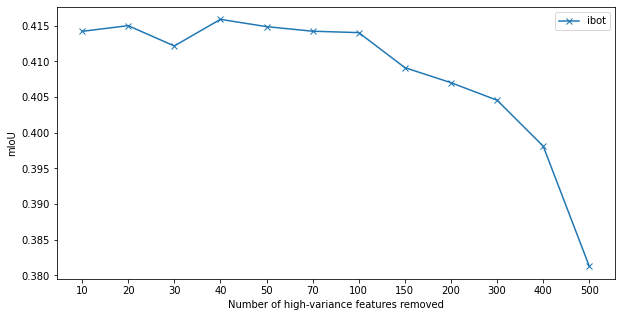

In [85]:
plt.figure(figsize=(10, 5))
drops = [10, 20, 30, 40, 50, 70, 100, 150, 200, 300, 400, 500]
for mi, model in enumerate(models):
    x = range(len(drops))
    plt.plot(x, results[model][:,-1], marker='x', color=f'C{mi}', label=model);
#     plt.plot(x, linear_results[model][:,-1], marker='o', color=f'C{mi}');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
# plt.ylim(0, 0.7)
plt.xticks(x, drops);

In [76]:
results['beit'].shape

(13, 20)

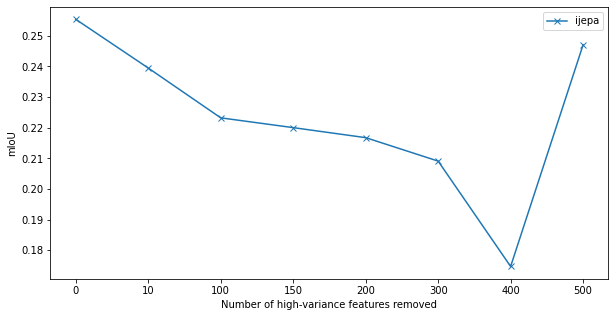

In [83]:
plt.figure(figsize=(10, 5))
drops = [0, 10, 100, 150, 200, 300, 400, 500]
for mi, model in enumerate(models):
    x = range(len(drops))
    plt.plot(x, results[model][:,-1], marker='x', color=f'C{mi}', label=model);
#     plt.plot(x, linear_results[model][:,-1], marker='o', color=f'C{mi}');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
# plt.ylim(0, 0.7)
plt.xticks(x, drops);

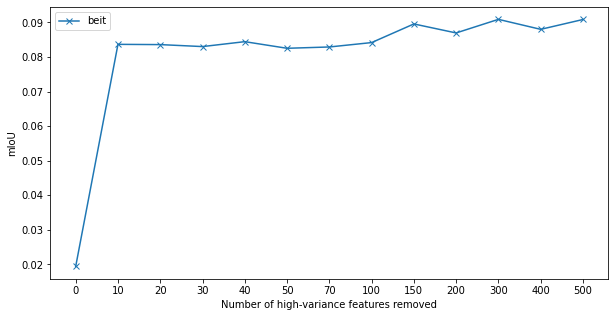

In [79]:
plt.figure(figsize=(10, 5))
for mi, model in enumerate(models):
    x = range(len(drops))
    plt.plot(x, results[model][:,-1], marker='x', color=f'C{mi}', label=model);
#     plt.plot(x, linear_results[model][:,-1], marker='o', color=f'C{mi}');
plt.ylabel("mIoU")
plt.xlabel("Number of high-variance features removed")
# plt.xscale('log')
# plt.xlim(10, 750)
plt.legend()
# plt.ylim(0, 0.7)
plt.xticks(x, drops);

In [38]:
plt.figure(figsize=(8, 5))
for model in ['mae', 'beit', 'ijepa', 'dino']:
    plt.plot(variances[model], label=model2name[model])

# plt.yscale('log')
# plt.xscale('log')
plt.ylim(top=100, bottom=0)
plt.legend()
plt.show()

KeyError: 'mae'

<Figure size 576x360 with 0 Axes>